# Keyword Extraction and Visualization using TF-IDF
## process and extract relevant keywords from the title, description and content fields to use as input for retrieving messages from Discord and Reddit.

## Load and Explore the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Loading the CSV file
data = pd.read_csv("newsapiorg.csv")

In [3]:
# Display the first few rows
print(data.head())

                                               Title  \
0  Lasers Are Making It Easier to Find Buried Lan...   
1  Spotify Wrapped is always a mess for parents. ...   
2  The Omnicom-IPG megamerger signals a new era f...   
3                        The Paper Passport Is Dying   
4           These 5 trends will steer retail in 2025   

                                         Description  \
0  The technology searches for buried objects by ...   
1  Spotify is using Google AI technology to make ...   
2  Omnicom Group is merging with Interpublic Grou...   
3  Smartphones and face recognition are being com...   
4  Technology will continue to profoundly impact ...   

                                             Content          Published At  \
0  scientists in the US have developed a technolo...  2024-12-04T09:00:00Z   
1  Spotify Wrapped uses Google's AI to make a pod...  2024-12-04T22:29:12Z   
2  Hello. Luigi Mangione, a 26-year-old Ivy Leagu...  2024-12-10T16:37:38Z   
3  In a matter

In [4]:
# Checking the column names and data types
print(data.info())

# Checking the number of rows and columns
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         404 non-null    object
 1   Description   404 non-null    object
 2   Content       404 non-null    object
 3   Published At  404 non-null    object
 4   Author        404 non-null    object
 5   Source        404 non-null    object
 6   URL           404 non-null    object
dtypes: object(7)
memory usage: 22.2+ KB
None
(404, 7)


In [5]:
# Checking for missing values
print(data.isnull().sum())

# Displaying the rows with missing data
print(data[data.isnull().any(axis=1)])

Title           0
Description     0
Content         0
Published At    0
Author          0
Source          0
URL             0
dtype: int64
Empty DataFrame
Columns: [Title, Description, Content, Published At, Author, Source, URL]
Index: []


Duplicates can bias the analysis, so identifying and optionally removing them is essential.

In [6]:
# Check for duplicate rows
print(f"Duplicate rows: {data.duplicated().sum()}")

# Display duplicate rows
print(data[data.duplicated()])

Duplicate rows: 95
                                                 Title  \
32   Business leaders share 5 ways they're taking A...   
39                                  2024 in review: AI   
42               It’s Time to Move Past AI Nationalism   
55   The Race to Translate Animal Sounds Into Human...   
56              The Inside Story of Apple Intelligence   
..                                                 ...   
395  VCs say digital agents, 'crypto mania,' and a ...   
397           42 Best Cyber Monday Camera Deals (2024)   
399  Will the world's fastest supercomputer please ...   
401  Meet 45 rising stars of the venture capital in...   
403  AWS announces Aurora DSQL, a new distributed S...   

                                           Description  \
32   Leaders from Mastercard, Infosys, IBM, and mor...   
39   2024 was the year tech companies scrambled for...   
42   Countries must collaborate if we’re going to c...   
55   With big cash prizes at stake—and AI superchar.

In [7]:
# Remove duplicate rows
data = data.drop_duplicates(subset=['Title', 'Description', 'Content'], keep='first')

# Verify removal
print(f"Number of duplicate rows after removal: {data.duplicated().sum()}")

# Save the cleaned dataset
data.to_csv("cleaned_dataset.csv", index=False)

Number of duplicate rows after removal: 0


## Analyzing Text Fields

In [8]:
# Analyze the length of text in Title, Description, and Content
data['Title_length'] = data['Title'].fillna("").apply(len)
data['Description_length'] = data['Description'].fillna("").apply(len)
data['Content_length'] = data['Content'].fillna("").apply(len)

# Display statistics for text lengths
print(data[['Title_length', 'Description_length', 'Content_length']].describe())

       Title_length  Description_length  Content_length
count    309.000000          309.000000      309.000000
mean      78.042071          142.048544      214.106796
std       24.377740           31.334925        0.424401
min       18.000000           61.000000      213.000000
25%       58.000000          127.000000      214.000000
50%       77.000000          143.000000      214.000000
75%       97.000000          151.000000      214.000000
max      139.000000          260.000000      216.000000


# The temporal scope of the dataset

In [9]:
# Convert the date column to datetime
data['Published At'] = pd.to_datetime(data['Published At'], errors='coerce')

# Check the range of dates
print(f"Date range: {data['Published At'].min()} to {data['Published At'].max()}")

# Count the number of articles per day
print(data['Published At'].dt.date.value_counts().sort_index())

Date range: 2024-11-29 20:51:53+00:00 to 2024-12-29 20:41:06+00:00
Published At
2024-11-29     3
2024-11-30     5
2024-12-01     1
2024-12-02    20
2024-12-03    13
2024-12-04    21
2024-12-05     9
2024-12-06    11
2024-12-07     3
2024-12-08     4
2024-12-09    16
2024-12-10    15
2024-12-11    18
2024-12-12    20
2024-12-13    17
2024-12-14     7
2024-12-15     5
2024-12-16    14
2024-12-17    11
2024-12-18    16
2024-12-19    13
2024-12-20    13
2024-12-21     5
2024-12-22     5
2024-12-23    13
2024-12-24     5
2024-12-25     1
2024-12-26    11
2024-12-27     8
2024-12-28     4
2024-12-29     2
Name: count, dtype: int64


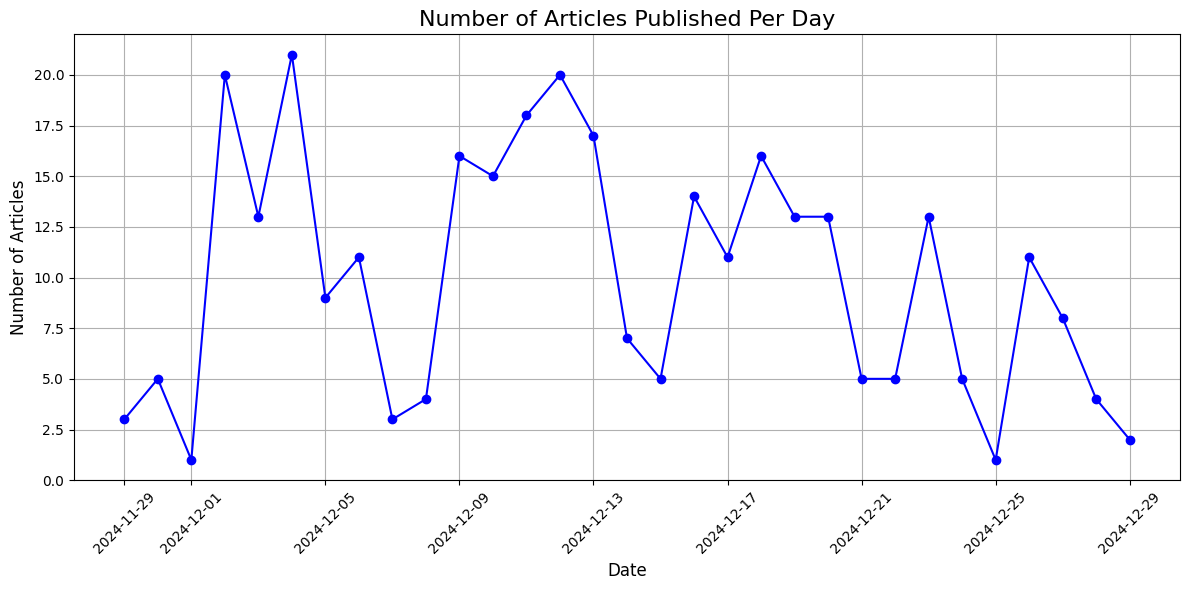

In [10]:
# Group by date and count the number of articles
articles_per_day = data['Published At'].dt.date.value_counts().sort_index()

# Plot the data
plt.figure(figsize=(12, 6))
articles_per_day.plot(kind='line', marker='o', color='blue')

# Add titles and labels
plt.title('Number of Articles Published Per Day', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

## Categorical Analysis

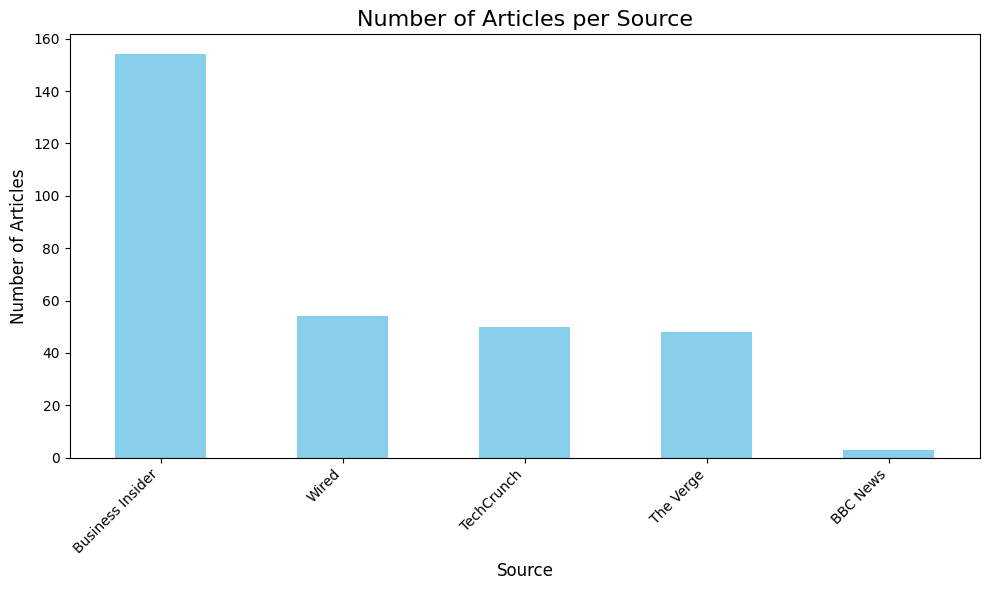

In [11]:
# Count the number of articles per source
source_counts = data['Source'].value_counts()

# Plot the data
plt.figure(figsize=(10, 6))
source_counts.plot(kind='bar', color='skyblue')

# Add titles and labels
plt.title('Number of Articles per Source', fontsize=16)
plt.xlabel('Source', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

## The bar chart shows the number of articles fetched for each source, helping  identify the most frequently referenced sources.

## Preprocessing the Text Fields

## combine the text fields into a single column to simplify processing

In [12]:
# Combine 'Title', 'Description', and 'Content' into a single text field
data['combined_text'] = data[['Title', 'Description', 'Content']].fillna('').agg(' '.join, axis=1)

# Preview the combined text
print(data['combined_text'].head())

0    Lasers Are Making It Easier to Find Buried Lan...
1    Spotify Wrapped is always a mess for parents. ...
2    The Omnicom-IPG megamerger signals a new era f...
3    The Paper Passport Is Dying Smartphones and fa...
4    These 5 trends will steer retail in 2025 Techn...
Name: combined_text, dtype: object


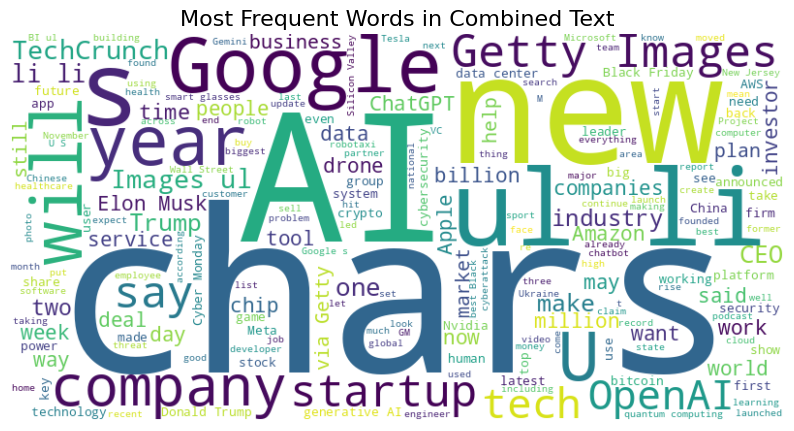

In [13]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['combined_text']))

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Combined Text', fontsize=16)
plt.show()

## Cleaning the text by removing stopwords, punctuation, and special characters

In [14]:

# Download stopwords if not already downloaded
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply cleaning to the combined text column
data['cleaned_text'] = data['combined_text'].apply(clean_text)

# Preview the cleaned text
print(data['cleaned_text'].head())

0    lasers making easier find buried land mines te...
1    spotify wrapped always mess parents new ai pod...
2    omnicomipg megamerger signals new era ad indus...
3    paper passport dying smartphones face recognit...
4    trends steer retail technology continue profou...
Name: cleaned_text, dtype: object


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


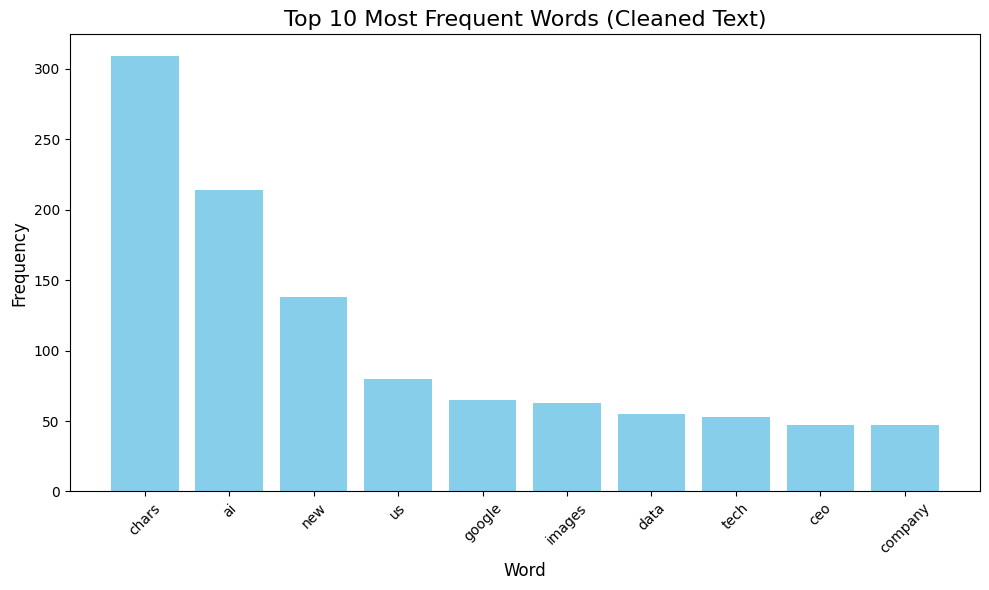

In [15]:


# Count word frequencies
word_counts = Counter(' '.join(data['cleaned_text']).split())
most_common_words = word_counts.most_common(10)

# Convert to DataFrame for visualization
word_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

# Plot the top words
plt.figure(figsize=(10, 6))
plt.bar(word_df['Word'], word_df['Frequency'], color='skyblue')
plt.title('Top 10 Most Frequent Words (Cleaned Text)', fontsize=16)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Lemmatization :Lemmatizing the words to reduce them to their base or root form

In [16]:


# Download WordNet if not already downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join(lemmatizer.lemmatize(word) for word in text.split())

# Apply lemmatization
data['lemmatized_text'] = data['cleaned_text'].apply(lemmatize_text)

# Preview the lemmatized text
print(data['lemmatized_text'].head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


0    laser making easier find buried land mine tech...
1    spotify wrapped always mess parent new ai podc...
2    omnicomipg megamerger signal new era ad indust...
3    paper passport dying smartphones face recognit...
4    trend steer retail technology continue profoun...
Name: lemmatized_text, dtype: object


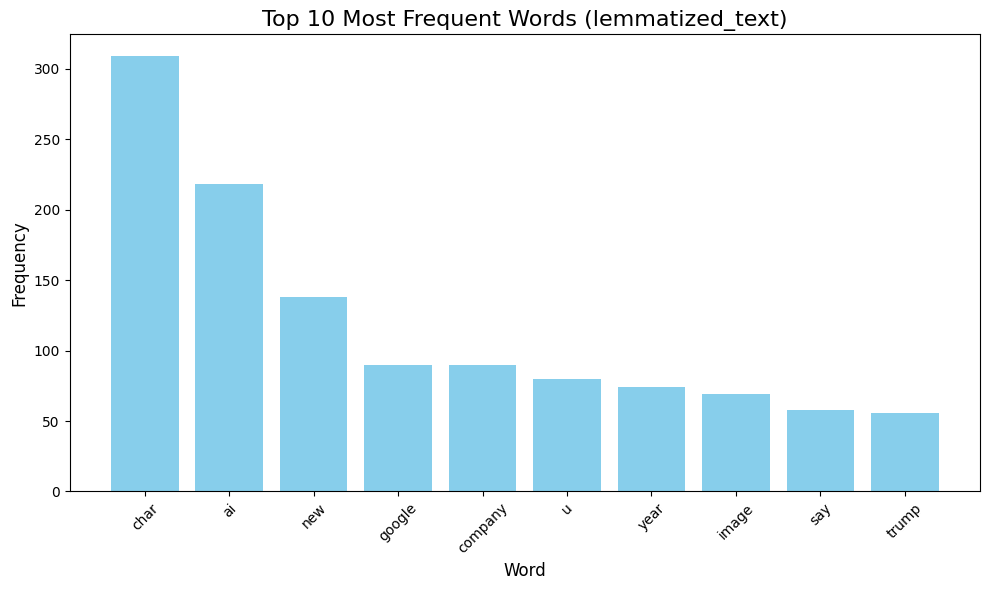

In [17]:
# Count word frequencies
word_counts = Counter(' '.join(data['lemmatized_text']).split())
most_common_words = word_counts.most_common(10)

# Convert to DataFrame for visualization
word_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

# Plot the top words
plt.figure(figsize=(10, 6))
plt.bar(word_df['Word'], word_df['Frequency'], color='skyblue')
plt.title('Top 10 Most Frequent Words (lemmatized_text)', fontsize=16)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Tokenization : Spliting the text into individual words (tokens) for further processing or modeling.

In [18]:
# Tokenize the lemmatized text
data['tokens'] = data['lemmatized_text'].apply(lambda x: x.split())

# Preview the tokens
print(data['tokens'].head())

0    [laser, making, easier, find, buried, land, mi...
1    [spotify, wrapped, always, mess, parent, new, ...
2    [omnicomipg, megamerger, signal, new, era, ad,...
3    [paper, passport, dying, smartphones, face, re...
4    [trend, steer, retail, technology, continue, p...
Name: tokens, dtype: object


In [19]:
# Save the processed data
data.to_csv("processed_text_data.csv", index=False)

## Keyword Extraction from Processed Text

We'll use TF-IDF (Term Frequency-Inverse Document Frequency) as it is a robust and widely-used technique for keyword extraction.

 ## Import Required Libraries

## Vectorizing the Text : Applying the TfidfVectorizer to calculate TF-IDF scores for words in the lemmatized_text column.

## Dynamic Search for the relevant number of keywords per document( ran once)

In [20]:
# # Initialize the vectorizer
# vectorizer = TfidfVectorizer()  # No max_features initially to experiment dynamically

# # Fit and transform the lemmatized text
# tfidf_matrix = vectorizer.fit_transform(data['lemmatized_text'])

# # Get the feature names (keywords)
# keywords = vectorizer.get_feature_names_out()

In [21]:
# # Define a function to extract top keywords for a document
# def extract_top_keywords(row, feature_names, top_n):
#     row_scores = row.toarray()[0]  # Get TF-IDF scores for the document
#     top_indices = row_scores.argsort()[-top_n:][::-1]  # Get indices of top-N scores
#     return [feature_names[i] for i in top_indices]

# # Test for different numbers of top keywords
# results = {}
# for top_n in [5, 10, 20, 30]:
#     # Extract top keywords for each document
#     results[top_n] = [
#         extract_top_keywords(tfidf_matrix[i], keywords, top_n=top_n)
#         for i in range(tfidf_matrix.shape[0])
#     ]

# # Add the selected number of keywords as new columns for comparison
# for top_n, keywords_list in results.items():
#     data[f'top_{top_n}_keywords'] = keywords_list

# # Visualize and compare results
# for top_n in [5, 10, 20, 30]:
#     print(f"\nTop {top_n} Keywords for Each Document:")
#     print(data[[f'top_{top_n}_keywords']].head())

In [22]:
# # Export the keywords to a CSV file
# data[['Title', 'top_5_keywords', 'top_10_keywords', 'top_20_keywords', 'top_30_keywords']].to_csv('keywords_comparison.csv', index=False)

# print("Keywords saved to 'keywords_comparison.csv'")

In [23]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=10)  # extracting top 10 keywords

# Fit and transform the lemmatized text
tfidf_matrix = vectorizer.fit_transform(data['lemmatized_text'])

# Get the feature names (keywords)
keywords = vectorizer.get_feature_names_out()

# Create a DataFrame to display keywords and their scores
keyword_scores = pd.DataFrame(tfidf_matrix.toarray(), columns=keywords)

# Preview the scores
print(keyword_scores.head())

         ai      char   company    google     image       new  say  startup  \
0  0.000000  1.000000  0.000000  0.000000  0.000000  0.000000  0.0      0.0   
1  0.642978  0.096771  0.000000  0.621308  0.000000  0.437255  0.0      0.0   
2  0.000000  0.404751  0.000000  0.000000  0.000000  0.914427  0.0      0.0   
3  0.000000  0.136073  0.000000  0.000000  0.000000  0.922263  0.0      0.0   
4  0.000000  0.266017  0.677523  0.000000  0.685709  0.000000  0.0      0.0   

   trump      year  
0    0.0  0.000000  
1    0.0  0.000000  
2    0.0  0.000000  
3    0.0  0.361823  
4    0.0  0.000000  


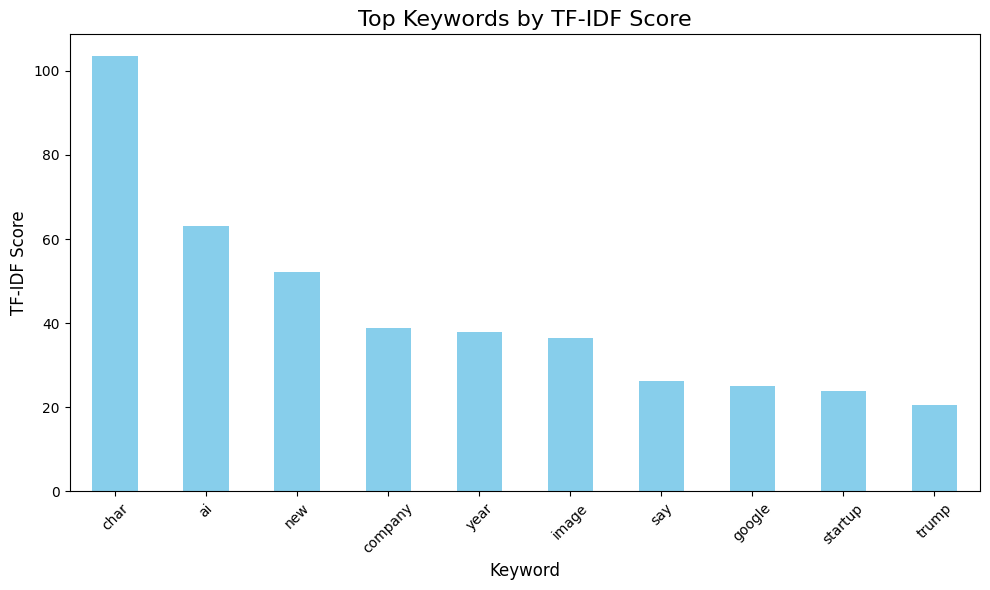

In [24]:
# Aggregate TF-IDF scores across all documents
aggregated_scores = keyword_scores.sum().sort_values(ascending=False)

# Plot the top keywords
plt.figure(figsize=(10, 6))
aggregated_scores.plot(kind='bar', color='skyblue')
plt.title('Top Keywords by TF-IDF Score', fontsize=16)
plt.xlabel('Keyword', fontsize=12)
plt.ylabel('TF-IDF Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
# Define custom stopwords
custom_stopwords = ['char', 'ai', 'new', 'year', 'say']

# Filter out custom stopwords
data['lemmatized_text'] = data['lemmatized_text'].apply(
    lambda x: ' '.join(word for word in x.split() if word not in custom_stopwords)
)

In [26]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())  # Lemmatize words
    return text

# Apply preprocessing
data['lemmatized_text'] = data['lemmatized_text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [27]:
# Initialize vectorizer with n-grams
vectorizer = TfidfVectorizer(max_features=10, ngram_range=(1, 2))  # Extract unigrams and bigrams

# Fit and transform the lemmatized text
tfidf_matrix = vectorizer.fit_transform(data['lemmatized_text'])

# Get feature names (keywords)
keywords = vectorizer.get_feature_names_out()

# Create a DataFrame to display keywords and their scores
keyword_scores = pd.DataFrame(tfidf_matrix.toarray(), columns=keywords)

# Preview the scores
print("Updated Keyword Scores:")
print(keyword_scores.head())

Updated Keyword Scores:
        ceo   company      data  deal  google    image  startup  tech  \
0  0.000000  0.000000  0.000000   0.0     0.0  0.00000      0.0   0.0   
1  0.000000  0.000000  0.000000   0.0     1.0  0.00000      0.0   0.0   
2  0.685558  0.000000  0.728018   0.0     0.0  0.00000      0.0   0.0   
3  0.000000  0.000000  0.000000   0.0     0.0  0.00000      0.0   0.0   
4  0.000000  0.702848  0.000000   0.0     0.0  0.71134      0.0   0.0   

   techcrunch  trump  
0         0.0    0.0  
1         0.0    0.0  
2         0.0    0.0  
3         0.0    0.0  
4         0.0    0.0  


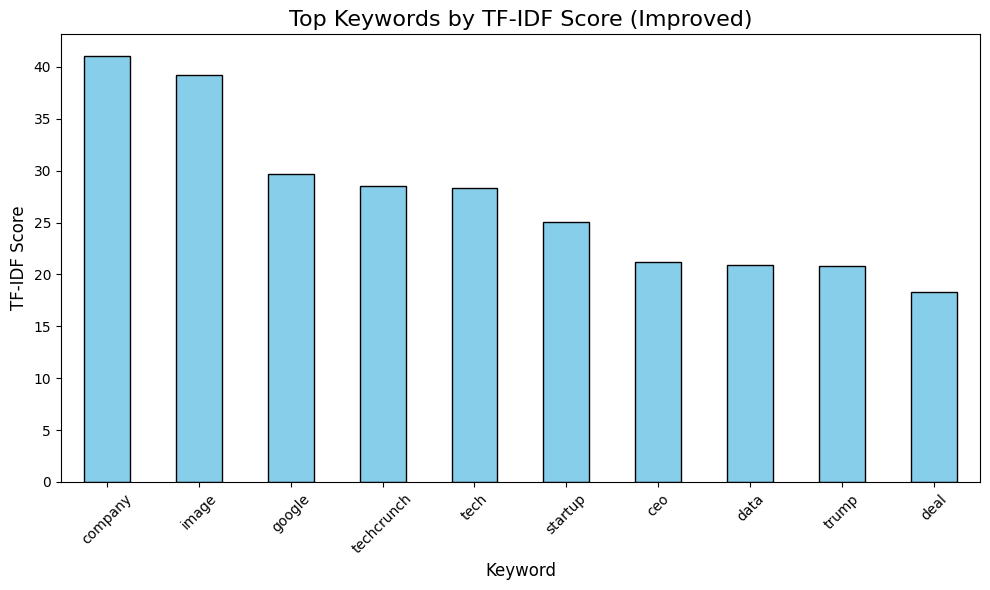

In [28]:
# Sum TF-IDF scores for each keyword
keyword_importance = keyword_scores.sum().sort_values(ascending=False)

# Plot the top keywords
plt.figure(figsize=(10, 6))
keyword_importance.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top Keywords by TF-IDF Score (Improved)', fontsize=16)
plt.xlabel('Keyword', fontsize=12)
plt.ylabel('TF-IDF Score', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

## Analyze the Keywords

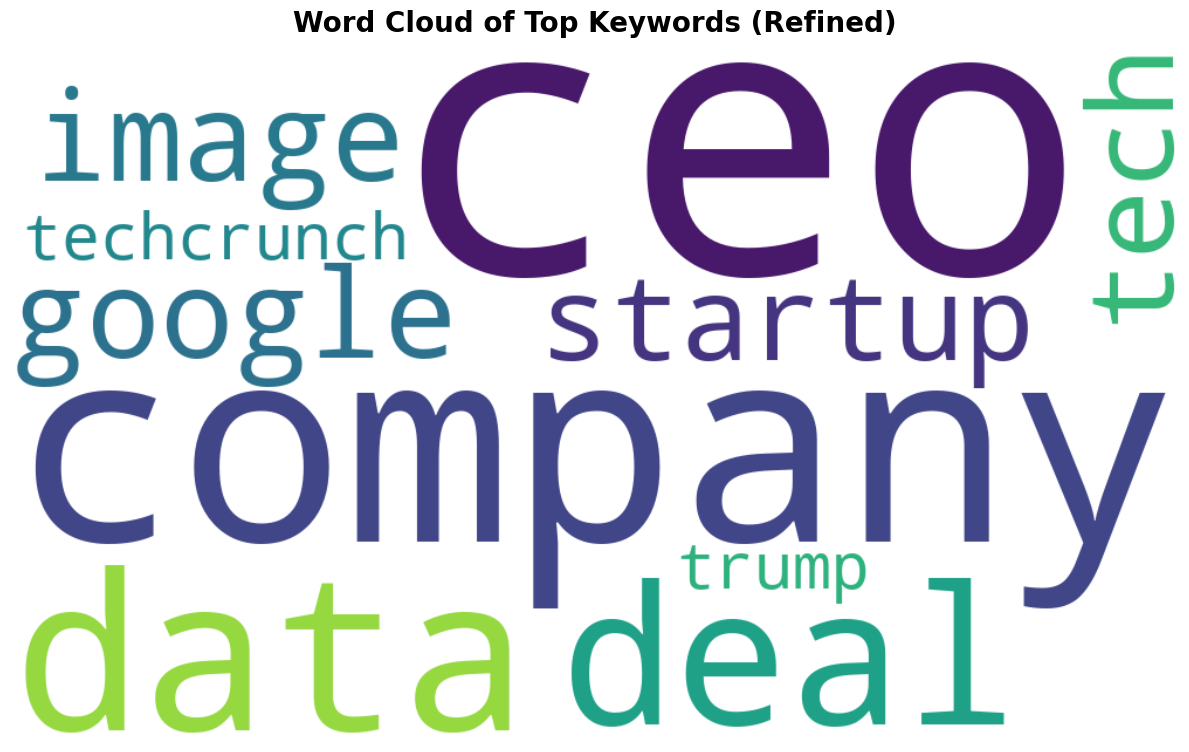

In [32]:
# Combine all top keywords into a single string for the word cloud
# Assuming keywords are extracted and stored in the `keywords` list from your current code
combined_keywords = ' '.join(keywords)  # Join the keywords into a single string

# Generate a word cloud
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    colormap='viridis',  # Use a visually appealing colormap
    max_words=600,  # Limit the number of words in the word cloud
    contour_width=3,
    contour_color='steelblue'
).generate(combined_keywords)

# Display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axes for a clean visualization
plt.title('Word Cloud of Top Keywords (Refined)', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()


## Save the Keywords

In [30]:
# Save the keywords DataFrame to a CSV file
keyword_scores.to_csv('extracted_keywords.csv', index=False)

# Print confirmation message
print("Keywords saved to 'extracted_keywords.csv'")

Keywords saved to 'extracted_keywords.csv'
